In [1]:
from __future__ import division
%matplotlib inline
import matplotlib.pyplot as plt
from postBornCrossSpectra import PostBorn_Bispec
import numpy as np
import Cosmology as C
import pickle
from scipy.integrate import simps
from scipy.interpolate import RectBivariateSpline
from classy import Class

import copy
import kernels
plt.style.use(['seaborn-colorblind','paper'])
plt.style.use('classic')

In [2]:
plotpath = './CrossPostBorn/results/plots/vanessa/'

In [3]:
zmin = 1e-5
zmax = 1090.

kmin = 1e-4
kmax = 10

cosmo = C.Planck2015

a     = np.linspace(1./(1.+zmin),1./(1.+zmax),100)  
z     = 1./a-1.

data      = C.CosmoData(cosmo[1],z)

LSST_bin  = 'all'

L   = np.logspace(1,4,100)


computing distances, derived parameters...
{'Neff': 3.046}
{'h': 0.68}
{'m_ncdm_tot': 0.0}
{'omega_m': 0.6608555034063286}


In [4]:
def get_31_term(L,L1,M):
    res=[]
    for L_ in L:
        res+=[simps(M(L_,L1,grid=False)/L1,L1)]

    res= np.asarray(res)
    res*=-1/(2*np.pi)*L**2
    return res

In [6]:
def get_22_term1(L,L1,phi,M):
    lint=[]
    cosphi= np.cos(phi)
    for L_ in L:
        phiint=[]
        for L1_ in L1:
            LL = np.sqrt(L_**2+L1_**2-2*L1_*L_*cosphi)
            LL[np.where(LL==0.)]=1e-12
            
            num = L_**2*cosphi**2*(L_*cosphi-L1_)**2
            num[np.where(LL<1e-12)]=0.
            denom = LL**4
            phiint+=[simps(M(L1_,LL,grid=False)*num/denom,phi)]

        phiint= np.asarray(phiint)
        lint+=[simps(phiint*L1,L1)]
    res=4./(2*np.pi)**2*np.asarray(lint)
    return res


def get_22_term2(L,L1,phi,M):
    
    lint =[]
    cosphi = np.cos(phi)
    
    for L_ in L:
        
        phiint=[]
        
        for L1_ in L1:
            
            LL = np.sqrt(L_**2+L1_**2+2*L1_*L_*cosphi)
            LL[np.where(LL==0.)]=1e-12
            
            num = (L1_*cosphi+L_)**2*(L1_*cosphi+L1_**2/L_)**2

            phiint+=[simps(M(LL,L1_,grid=False)*num,phi)]

        phiint= np.asarray(phiint)
        lint+=[simps(phiint/L1**3,L1)]
        
    res=4./(2*np.pi)**2*np.asarray(lint)
    
    return res

In [7]:
# first test for CMB lensing auto spectrum, change second kernel to initialize for cross
first_kernel  = kernels.CMB_lens(data.chi_cmb,data)
simple_kernel = kernels.CMB_lens(None,data)
second_kernel = kernels.CMB_lens(data.chi_cmb,data)#kernels.gal_clus(kernels.dNdz_LSST,kernels.simple_bias,data,LSST_bin)

PB1 = PostBorn_Bispec(data, zmin, data.z_cmb, first_kernel, second_kernel, simple_kernel, k_min=kmin,k_max=kmax, lmax=None, acc=1)

Initializing CLASS with halofit...
{'k_step_super': 0.0001, 'tol_perturb_integration': 1e-06, 'perturb_sampling_stepsize': 0.01, 'k_step_super_reduction': 0.1, 'k_max_tau0_over_l_max': 5.0, 'ln10^{10}A_s': 3.062, 'h': 0.68, 'z_max_pk': 1088.8072653000208, 'non linear': 'halofit', 'omega_cdm': 0.119, 'Omega_k': 0.0, 'k_pivot': 0.05, 'k_per_decade_for_pk': 20, 'P_k_max_1/Mpc': 11, 'k_min_tau0': 0.002, 'output': 'mPk', 'omega_b': 0.0223, 'n_s': 0.97, 'k_step_sub': 0.015, 'halofit_k_per_decade': 3000.0}
sigma8  0.829731941223
('zmax', 1088.8072653000208)


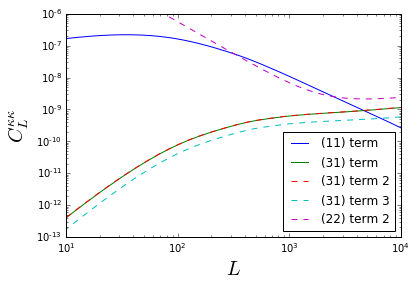

In [16]:
phi=np.linspace(0,2*np.pi,400)
plt.figure()
plt.loglog(PB1.ls,PB1.CL_born,label='(11) term')
L1=np.logspace(-1,4,200)
#(31)-term, multiply by two to get (31)+(13)
reskk = get_31_term(L,L1,PB1.Mstarsp)
plt.loglog(L,-reskk,label='(31) term')
#(31)-term, multiply by two to get (31)+(13)
L1=np.logspace(-3,4,400)
reskk = get_31_term(L,L1,PB1.Mstarsp)
plt.loglog(L,-reskk,label='(31) term 2',ls='--')
L1=np.logspace(-3,4,400)
reskk = get_31_term(L1,L,PB1.Mstarsp)
plt.loglog(L1,-reskk,label='(31) term 3',ls='--')
L1=np.logspace(-6,5,400)
reskk = get_22_term2(L1,L1,phi,PB1.Mstarsp)
plt.loglog(L1,reskk,label='(22) term 2',ls='--')
plt.xlim(10,10000)
plt.ylim(1e-13,1e-6)
plt.legend(loc='best')
plt.ylabel('$C_L^{\kappa\kappa}$',fontsize=20)
plt.xlabel('$L$',fontsize=20)
plt.savefig(plotpath+'cl_kk_pB_L1min%d.pdf'%(min(L1)), bbox_inches='tight')
plt.show()

In [19]:
# first test for CMB lensing auto spectrum, change second kernel to initialize for cross
first_kernel  = kernels.CMB_lens(data.chi_cmb,data)
simple_kernel = kernels.CMB_lens(None,data)
second_kernel = kernels.gal_clus(kernels.dNdz_LSST,kernels.simple_bias,data,LSST_bin)

PB2 = PostBorn_Bispec(data, zmin, data.z_cmb, first_kernel, second_kernel, simple_kernel, k_min=1e-4,k_max=kmax, lmax=None, acc=1)

#(31)-term, multiply by two to get (31)+(13)


using z-bin None norm 65.6723025802
Initializing CLASS with halofit...
{'k_step_super': 0.0001, 'tol_perturb_integration': 1e-06, 'perturb_sampling_stepsize': 0.01, 'k_step_super_reduction': 0.1, 'k_max_tau0_over_l_max': 5.0, 'ln10^{10}A_s': 3.062, 'h': 0.68, 'z_max_pk': 1088.8072653000208, 'non linear': 'halofit', 'omega_cdm': 0.119, 'Omega_k': 0.0, 'k_pivot': 0.05, 'k_per_decade_for_pk': 20, 'P_k_max_1/Mpc': 11, 'k_min_tau0': 0.002, 'output': 'mPk', 'omega_b': 0.0223, 'n_s': 0.97, 'k_step_sub': 0.015, 'halofit_k_per_decade': 3000.0}
sigma8  0.829731941223
('zmax', 1088.8072653000208)


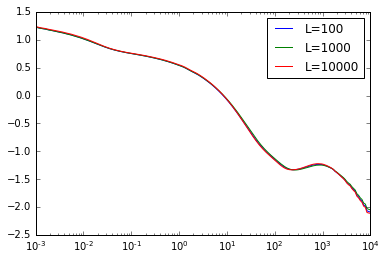

In [8]:
plt.figure()
for L_ in [100,1000,10000]:
    dlnMdlnL1=L1*PB2.Mstarsp(L_,L1,dx=0,dy=1)/PB2.Mstarsp(L_,L1,dx=0,dy=0)
    plt.semilogx(L1,dlnMdlnL1[0],label='L=%d'%L_)
    
plt.legend()
plt.show()


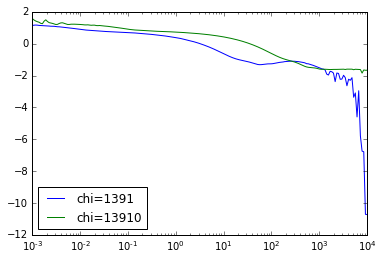

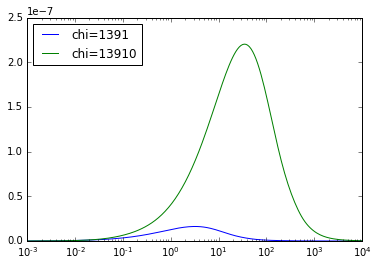

In [9]:
plt.figure()
for cc in [data.chi_cmb/10.,data.chi_cmb]:
    dlnM1dlnL1=L1*PB2.inner_int(cc,L1,dx=0,dy=1)/PB2.inner_int(cc,L1,dx=0,dy=0)
    plt.semilogx(L1,dlnM1dlnL1[0],label='chi=%d'%cc)
    
plt.legend(loc='best')
plt.show()

plt.figure()
for cc in [data.chi_cmb/10.,data.chi_cmb]:
    dlnM1dlnL1=PB2.inner_int(cc,L1,dx=0,dy=0)
    plt.semilogx(L1,dlnM1dlnL1[0],label='chi=%d'%cc)
    
plt.legend(loc='best')
plt.show()

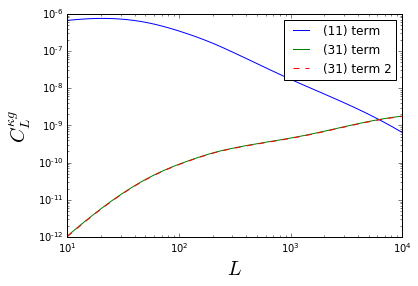

In [21]:

plt.figure()
plt.loglog(PB2.ls,PB2.CL_born,label='(11) term')
L1=np.logspace(-5,4,1000)
reskg = get_31_term(L,L1,PB2.Mstarsp)
plt.loglog(L,-reskg,label='(31) term')
L1=np.logspace(-1,4,1000)
reskg = get_31_term(L,L1,PB2.Mstarsp)
plt.loglog(L,-reskg,label='(31) term 2',ls='--')
plt.xlim(10,10000)
plt.legend()
plt.ylabel('$C_L^{\kappa g}$',fontsize=20)
plt.xlabel('$L$',fontsize=20)
plt.ylim(1e-12,1e-6)
plt.savefig(plotpath+'cl_kg_pB_L1min%d.pdf'%(min(L1)), bbox_inches='tight')

plt.show()

In [ ]:
PB2.Mstarsp(L,L1)

In [23]:
# first test for CMB lensing auto spectrum, change second kernel to initialize for cross
first_kernel  = kernels.gal_lens((0,1),data, p_chi=kernels.p_delta(data,1.))
simple_kernel = kernels.CMB_lens(None,data)
second_kernel = kernels.gal_lens((0,1),data, p_chi=kernels.p_delta(data,1.))

PB3 = PostBorn_Bispec(data, zmin, data.z_cmb, first_kernel, second_kernel, simple_kernel, k_min=kmin,k_max=kmax, lmax=None, acc=1)

#(31)-term, multiply by two to get (31)+(13)
resgamgam = get_31_term(L,L1,PB3.Mstarsp)

1.67511911725e-05
1.67511911725e-05
Initializing CLASS with halofit...
{'k_step_super': 0.0001, 'tol_perturb_integration': 1e-06, 'perturb_sampling_stepsize': 0.01, 'k_step_super_reduction': 0.1, 'k_max_tau0_over_l_max': 5.0, 'ln10^{10}A_s': 3.062, 'h': 0.68, 'z_max_pk': 1088.8072653000208, 'non linear': 'halofit', 'omega_cdm': 0.119, 'Omega_k': 0.0, 'k_pivot': 0.05, 'k_per_decade_for_pk': 20, 'P_k_max_1/Mpc': 11, 'k_min_tau0': 0.002, 'output': 'mPk', 'omega_b': 0.0223, 'n_s': 0.97, 'k_step_sub': 0.015, 'halofit_k_per_decade': 3000.0}
sigma8  0.829731941223
('zmax', 1088.8072653000208)


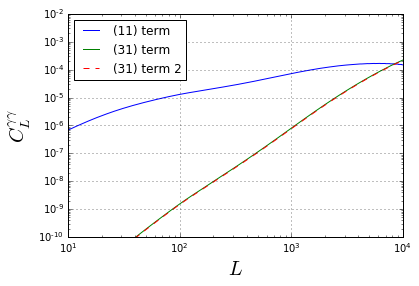

In [24]:

plt.figure()
plt.loglog(PB3.ls,PB3.ls**2*PB3.CL_born/(2*np.pi),label='(11) term')
L1=np.logspace(-5,4)
resgamgam = get_31_term(L,L1,PB3.Mstarsp)
plt.loglog(L,-L**2*resgamgam/(2*np.pi),label='(31) term')
L1=np.logspace(-1,4)
resgamgam = get_31_term(L,L1,PB3.Mstarsp)
plt.loglog(L,-L**2*resgamgam/(2*np.pi),label='(31) term 2', ls='--')
plt.xlim(10,10000)
plt.legend(loc='upper left')
plt.ylabel('$C_L^{\gamma \gamma}$',fontsize=20)
plt.xlabel('$L$',fontsize=20)
plt.grid()
plt.ylim(1e-10,1e-2)
plt.savefig(plotpath+'cl_gamgam_pB_L1min%d.pdf'%(min(L1)), bbox_inches='tight')
plt.show()

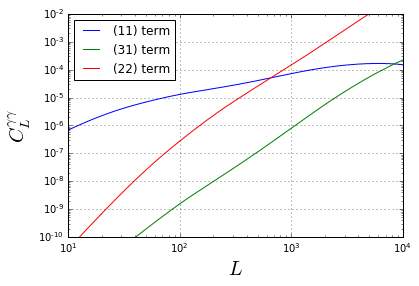

In [56]:
L1 = np.logspace(-3,np.log10(20000),400)
phi = np.linspace(0,2.*np.pi,400)
L = L1
term2 = get_22_term(L,L1,phi,PB2.Mstarsp)
resgamgam = get_31_term(L,L1,PB3.Mstarsp)
plt.figure()
plt.loglog(PB3.ls,PB3.ls**2*PB3.CL_born/(2*np.pi),label='(11) term')
plt.loglog(L,-L**2*resgamgam/(2*np.pi),label='(31) term')
plt.loglog(L,L**2*term2/(2*np.pi),label='(22) term')
plt.xlim(10,10000)
plt.legend(loc='upper left')
plt.ylabel('$C_L^{\gamma \gamma}$',fontsize=20)
plt.xlabel('$L$',fontsize=20)
plt.grid()
plt.ylim(1e-10,1e-2)
plt.savefig(plotpath+'cl_gamgam_pB_L1min%d.pdf'%(min(L1)), bbox_inches='tight')
plt.show()